Imports the libraries

In [ ]:
import numpy as np
from tensorflow import keras
from keras import layers, models, utils
from sklearn.model_selection import train_test_split

Load dataset

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range and reshape for input shape
x_train = x_train.reshape((-1, 28, 28, 1)).astype("float32") / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)).astype("float32") / 255.0

# Print training shape & samples
print("X_train shape: ", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


11490434/11490434 [==============================] - 0s 0us/step
X_train shape:  (60000, 28, 28, 1)
60000 train samples
10000 test samples


Display an image from the training dataset

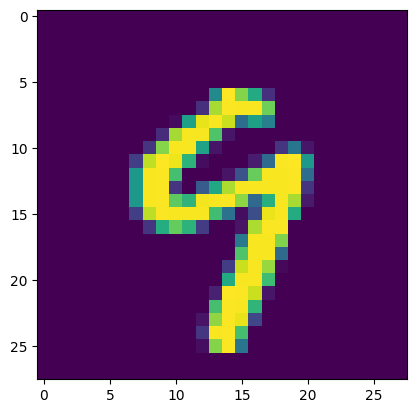

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[50145])

Splitting training data for multiple clients

In [ ]:
x_train_splits = np.array_split(x_train, 4)
y_train_splits = np.array_split(y_train, 4)

In [ ]:
x_train_splits[0].shape

(15000, 28, 28, 1)

Model Designing

In [ ]:
def create_model():
    model = models.Sequential(
        [
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dense(128, activation="relu"),
          layers.Dropout(0.5),
          layers.Dense(num_classes, activation="softmax")
      ]
    )
    return model

Creating multiple clients (models)

In [ ]:
model = []
for i in range(4):
  model.append(create_model())

In [ ]:
model[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

Compiling model

In [ ]:
for i in range(4):
  model[i].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Training model

In [ ]:
batch_size = 128
epochs = 5

for i in range(4):
    print("Training %s model: " % (i))
    model[i].fit(x_train_splits[i], y_train_splits[i], validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs)

Training 0 model: 
Epoch 1/5
118/118 [==============================] - 17s 130ms/step - loss: 0.6385 - accuracy: 0.8120 - val_loss: 0.2359 - val_accuracy: 0.9302
Epoch 2/5
118/118 [==============================] - 12s 98ms/step - loss: 0.2596 - accuracy: 0.9234 - val_loss: 0.1398 - val_accuracy: 0.9588
Epoch 3/5
118/118 [==============================] - 9s 72ms/step - loss: 0.1759 - accuracy: 0.9474 - val_loss: 0.1067 - val_accuracy: 0.9671
Epoch 4/5
118/118 [==============================] - 7s 57ms/step - loss: 0.1337 - accuracy: 0.9594 - val_loss: 0.0877 - val_accuracy: 0.9733
Epoch 5/5
118/118 [==============================] - 8s 71ms/step - loss: 0.1070 - accuracy: 0.9672 - val_loss: 0.0764 - val_accuracy: 0.9753
Training 1 model: 
Epoch 1/5
118/118 [==============================] - 9s 73ms/step - loss: 0.6382 - accuracy: 0.8089 - val_loss: 0.2282 - val_accuracy: 0.9339
Epoch 2/5
118/118 [==============================] - 7s 61ms/step - loss: 0.2591 - accuracy: 0.9248 - val_l

Model evaluation on test data

In [ ]:
score = model[0].evaluate(x_test, y_test, verbose=0)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.07644601166248322
Test accuracy:  0.9753000140190125


Taking aggregation

In [ ]:
predictions = []

for i in range(4):
  predictions.append(model[i].predict(x_test))

313/313 [==============================] - 2s 5ms/step


Getting weights for each model

In [ ]:
w0 = model[0].get_weights()
w1 = model[1].get_weights()
w2 = model[2].get_weights()
w3 = model[3].get_weights()

In [ ]:
pairwise_dist = np.vstack((w0, w1, w2, w3))

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Taking average

In [ ]:
avg_weights = np.average(pairwise_dist, axis=0)
avg_weights[0].shape

(3, 3, 1, 32)

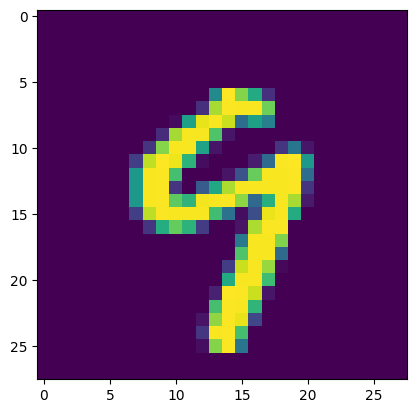

In [ ]:
plt.imshow(x_train[50145])